# Identifying hot pixels


## Some pixels are too hot

[*Click here to comment on this section on GitHub (opens in new tab).*](https://github.com/mwcraig/ccd-reduction-and-photometry-guide/pull/204/files#diff-2c14c2dd0cde6cccd807515b609eec8cR14){:target="_blank"}

Recall from the [notebook about dark current](03-02-Real-dark-current-noise-and-other-artifacts.html) that even  a
cryogenically-cooled camera with low dark current has some pixels with much
higher dark current. In the [discussion of "ideal" dark current](03-01-Dark-current-The-ideal-case.html) we noted that the
counts in a dark image should be proportional to the exposure time.

For some hot pixels that is not the case, unfortunately, which means that those
pixels cannot conveniently be corrected by subtracting a combined dark. Those pixels
can be identified by taking darks with two different (but long) exposure times
and comparing the dark current derived from each of the images. The dark
current, measured in electron/sec, should be the same in both images if the dark
current is really constant.

Fortunately, the pixels whose response is not proportional to exposure time are
usually also pixels with high dark current. It is possible to identify
those pixels and create a mask to exclude them when processing images. If this
weren't the case it might be necessary to take some dark frames with much longer
exposure times than otherwise needed.

In [1]:
from pathlib import Path

from matplotlib import pyplot as plt
import numpy as np

from astropy.visualization import hist
from astropy import units as u
from astropy.nddata import CCDData

import ccdproc as ccdp

In [2]:
# Use custom style for larger fonts and figures
plt.style.use('guide.mplstyle')

## Example

[*Click here to comment on this section on GitHub (opens in new tab).*](https://github.com/mwcraig/ccd-reduction-and-photometry-guide/pull/204/files#diff-2c14c2dd0cde6cccd807515b609eec8cR67){:target="_blank"}

There are two combined dark images available for the thermoelectrically-cooled
Andor Aspen CG16M discussed as "Example 2" in previous notebooks. One is an
average of ten 90 second exposures taken during observations of the transiting
exoplanet KELT-16 b. The other is an average of twenty 1,000 second exposures
taken during commission of the camera. Typically you will not have a single dark
of with an exposure time that long, let alone several of them.

We begin by reading each combined dark and calculating the dark current from the
counts in the image using

$$
\text{dark current} = \text{gain} \times \text{dark counts}~/ \text{ exposure time }.
$$

The gain for this camera is 1.5 $e^-$/adu. The 1,000 second exposure also needs
to be trimmed to remove the overscan region.

In [3]:
ex2_path = Path('example2-reduced')

dark_90 = CCDData.read(ex2_path / 'combined_dark_90.000.fit')
dark_1000 = CCDData.read('master_dark_exposure_1000.0.fit.bz2')
dark_1000 = ccdp.trim_image(dark_1000[:, :4096])

dark_90 = dark_90.multiply(1.5 * u.electron / u.adu).divide(90 * u.second)
dark_1000 = dark_1000.multiply(1.5 * u.electron / u.adu).divide(1000 * u.second)

The histogram below shows the distribution of dark current values in each image.
There are some differences we should *expect* to see between the two images.

Small values of dark current are much more accurately measured in the long
exposure. The exposure time in that image was chosen to be as short as possible
while still measuring the nominal dark current of 0.01 $e^-$/sec from the
manufacturer given that the camera's read noise is 10$e^-$.

For the average of ten 90 second exposures, that read noise will be reduced to
10$e^-/\sqrt{10} \approx$3.2$e^-$. After dividng by exposure time, this is
equivalent to a "dark current" of 0.035$e^-$/sec. Roughly twice that is the
smallest dark current that can be accurately measured in the 90 second dark.

For large values of dark current, the shorter exposure is more accurate. Some of
the pixels saturate (i.e., reach the maximum value the chip can read out, roughly
65,000) in under 90 sec and more of them saturate at some time between 90
seconds and 1,000 seconds. None of those pixels are accurately measured by the
long 1,000 second exposure time.

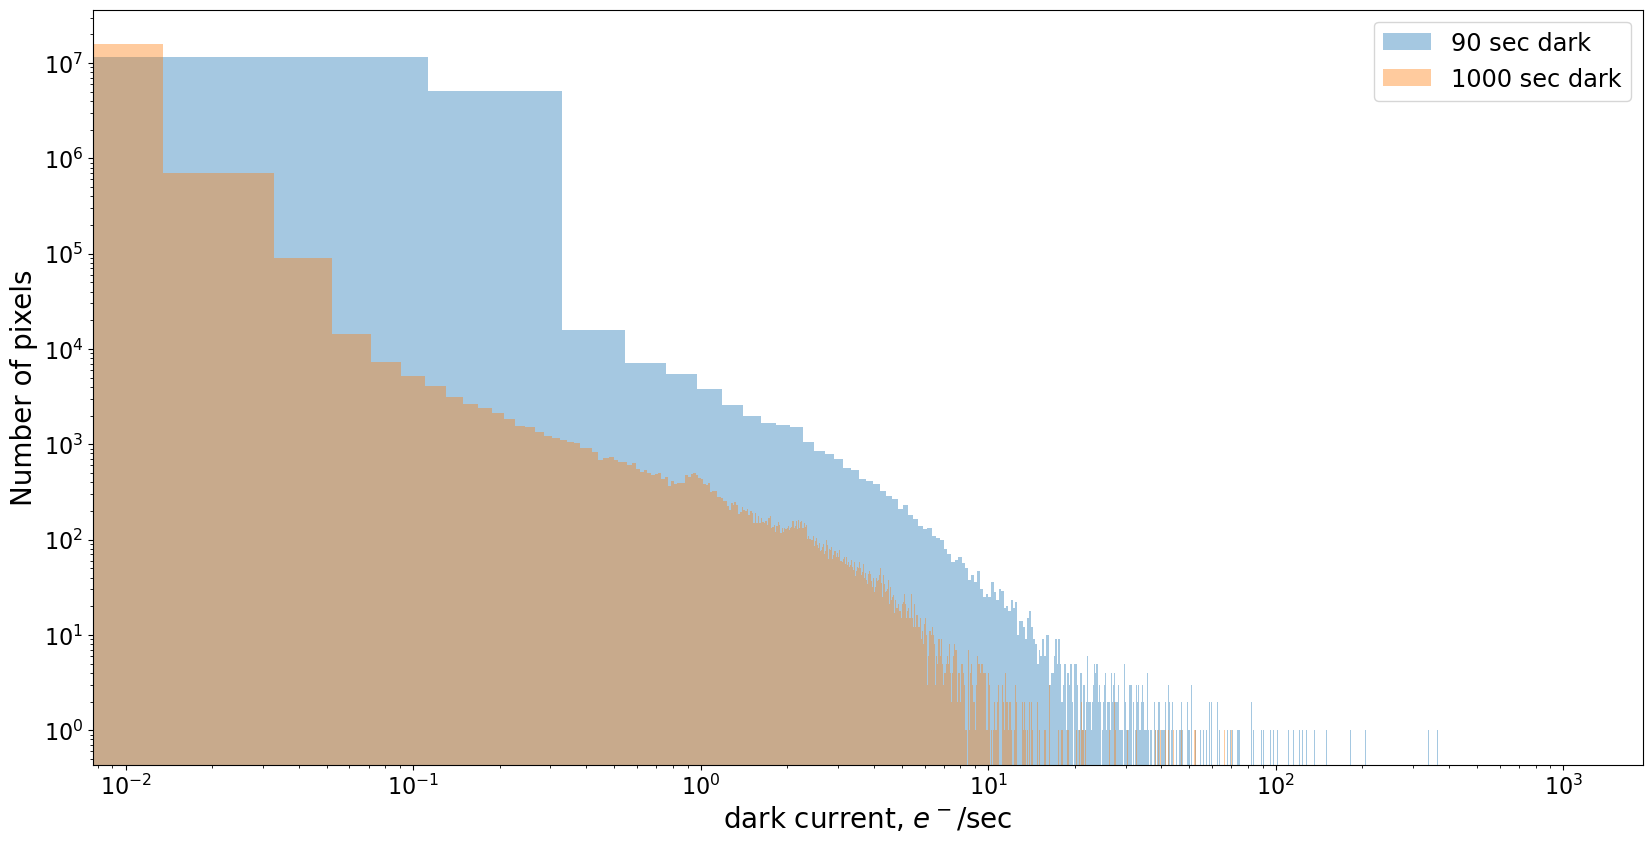

In [4]:
plt.figure(figsize=(20, 10))

hist(dark_90.data.flatten(), bins=5000, density=False, label='90 sec dark', alpha=0.4)
hist(dark_1000.data.flatten(), bins=5000, density=False, label='1000 sec dark', alpha=0.4)
plt.xlabel('dark current, $e^-$/sec')
plt.ylabel('Number of pixels')
plt.loglog()
plt.legend();

Overall, there appear to be more hot pixels in the 90 sec exposure than in the
1,000 sec exposure. For dark current under 0.1 $e^-$/sec, that is certainly
affected by the read noise in the 90 sec exposure.

To get a better idea of how consistent the dark current measurements are, we
construct a scatter plot with the measured dark current from each image for
those pixels in which the dark current is larger than 1$e^-$/sec as measured in
the longer exposure.

In [5]:
hot_pixels = (dark_1000.data > 1)

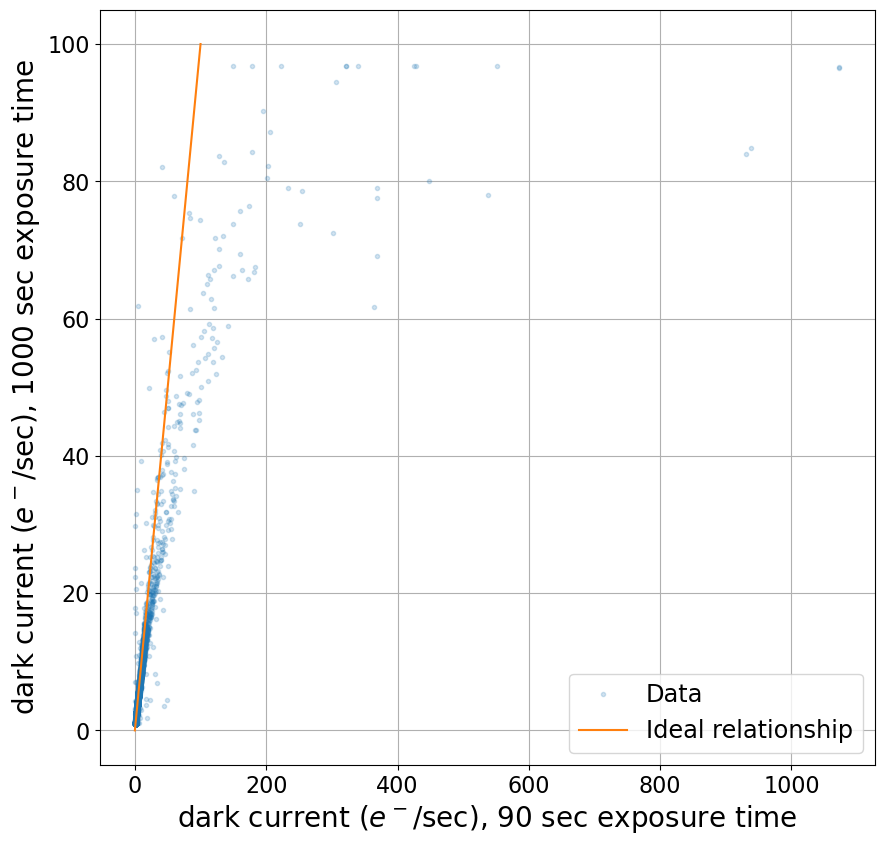

In [6]:
plt.figure(figsize=(10, 10))
plt.plot(dark_90.data[hot_pixels].flatten(), dark_1000.data[hot_pixels].flatten(), '.', alpha=0.2, label='Data')
plt.xlabel("dark current ($e^-$/sec), 90 sec exposure time")
plt.ylabel("dark current ($e^-$/sec), 1000 sec exposure time")
plt.plot([0, 100], [0, 100], label='Ideal relationship')
plt.grid()
plt.legend();

The upper limit on dark current that can be measured with the long exposure time
can be clearly seen in the plot above; there is a ceiling at roughly 95$e^-$/sec
above which the dark current in the long exposure does not go.

It looks like the dark current as measured in each frame is equal for lower
values of the dark current, so we replot to get a better look at that region.

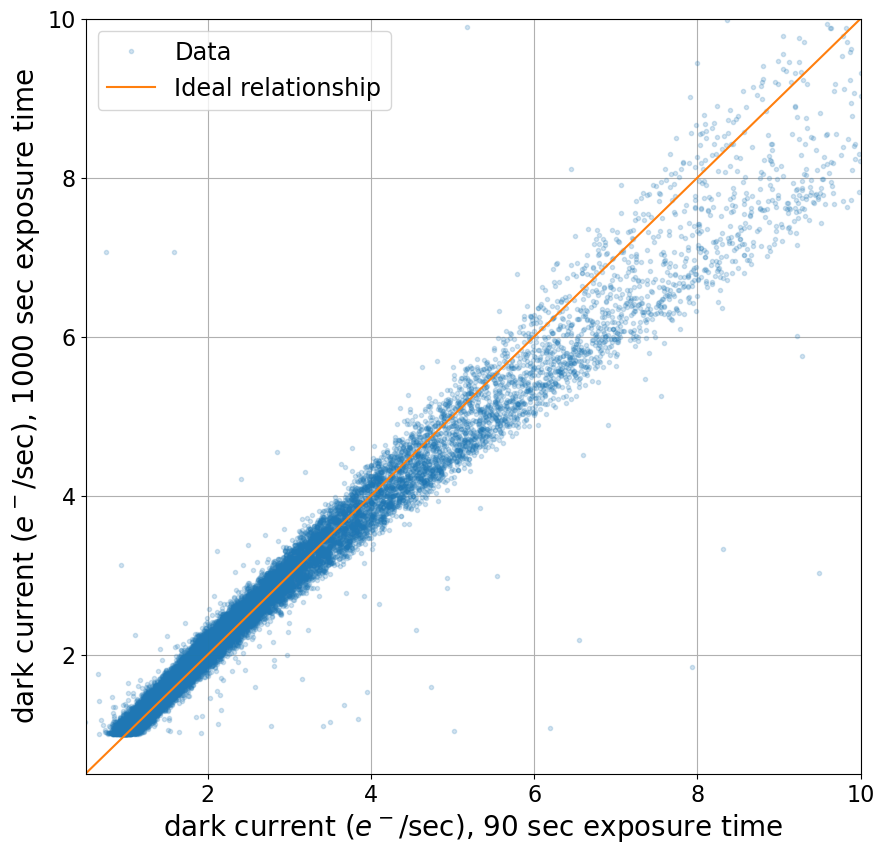

In [7]:
plt.figure(figsize=(10, 10))
plt.plot(dark_90.data[hot_pixels].flatten(), dark_1000.data[hot_pixels].flatten(), '.', alpha=0.2, label='Data')
plt.xlabel("dark current ($e^-$/sec), 90 sec exposure time")
plt.ylabel("dark current ($e^-$/sec), 1000 sec exposure time")
plt.plot([0, 100], [0, 100], label='Ideal relationship')
plt.grid()
plt.xlim(0.5, 10)
plt.ylim(0.5, 10)
plt.legend();

Here it looks like the measured dark currents are consistent until around
4$e^-$/sec. Beyond that the dark current is consistently larger in the short
exposure than in the long exposure.

Because of this, we will mark all pixels with dark current larger than
4$e^-$/sec as bad. Below that the dark current seems to be measured consistently
in both exposures so it ought to be possible to remove the dark current by
subtracting a combined dark frame.

In [8]:
bad_hot_pixels = (dark_90.data > 4)
bad_hot_pixels.sum()

4302

This amounts to 4302 pixels, or 0.026% of the pixels in the camera.

## Rule of thumb

[*Click here to comment on this section on GitHub (opens in new tab).*](https://github.com/mwcraig/ccd-reduction-and-photometry-guide/pull/204/files#diff-2c14c2dd0cde6cccd807515b609eec8cR250){:target="_blank"}

The example in this notebook is a little unusual in that a very long exposure
dark is available. In deciding what pixels to mask because of high dark current
you have a few options:

+ Use whatever exposure time range you have. The images in "Example 1" from the
previous notebook have darks with exposure times 7, 70, and 300 seconds. The 7
second dark is primarily measuring read noise, so is not likely to be useful.
The current in the 70 second and 300 second darks could be compared, though, as
it was in this case.
+ If that is not an option, as was the case with the data in "Example 2," then you
may need to pick a cutoff. Keep in mind that the typical camera has very, very
low dark current, so a limit like 1$e^-$/sec is not unreasonable.
+ Ask other users of the instrument what they do. Large observatories may
provide a mask image of bad pixels for the camera you are using.
+ Do not do any masking. This is a more reasonable option than you might think.
Most pixels are measuring light from the nighttime sky. If one of these hot
pixels happens to be in that background, and outlying pixels are rejected by a
method like sigma clipping, then these hot pixels will be excluded from your
analysis. If the object of interest happens to fall on one the bad pixels you
may well notice it. In time series photometry this sometimes manifests as a
single data point that is well outside the trend in the rest of the data.

## Saving the mask

[*Click here to comment on this section on GitHub (opens in new tab).*](https://github.com/mwcraig/ccd-reduction-and-photometry-guide/pull/204/files#diff-2c14c2dd0cde6cccd807515b609eec8cR279){:target="_blank"}

The mask can be saved as in a FITS file. We will see in the notebook [incorporating masks in science images](08-05-incorporating-masks-into-calibrated-science-images.html) how
to include this mask. Casting the mask as an unsigned integer is necessary
because FITS cannot store boolean data.

In [9]:
mask_as_ccd = CCDData(data=bad_hot_pixels.astype('uint8'), unit=u.dimensionless_unscaled)
mask_as_ccd.header['imagetyp'] = 'dark mask'
mask_as_ccd.write(ex2_path / 'mask_from_dark_current.fits')